In [2]:
!pip install duckdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 1.2 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [49]:
import os, duckdb

con = duckdb.connect()

# Ensure extensions are available
con.execute("INSTALL ducklake; LOAD ducklake;")
con.execute("INSTALL httpfs;   LOAD httpfs;")

# Attach + USE the lake safely (no dependence on pragma_database_list)
lake_path = "data/contentlake.ducklake"
os.makedirs("data", exist_ok=True)

try:
    con.execute("USE content_lake;")
except duckdb.Error:
    con.execute(f"ATTACH 'ducklake:{lake_path}' AS content_lake;")
    con.execute("USE content_lake;")

# Schemas
con.execute("CREATE SCHEMA IF NOT EXISTS raw;")
con.execute("CREATE SCHEMA IF NOT EXISTS curated;")

print("Lake ready ✅")


Lake ready ✅


In [9]:
import duckdb

con = duckdb.connect()

con.execute("INSTALL ducklake;")
con.execute("LOAD ducklake;")
con.execute("INSTALL httpfs;")
con.execute("LOAD httpfs;")

con.execute("ATTACH 'ducklake:data/contentlake.ducklake' AS content_lake;")
con.execute("USE content_lake;")

# optional schemas for organization
con.execute("CREATE SCHEMA IF NOT EXISTS raw;")
con.execute("CREATE SCHEMA IF NOT EXISTS curated;")


In [ ]:
con.execute("""
    CREATE OR REPLACE TABLE raw.search_logs AS
    SELECT * FROM read_csv_auto('/Volumes/Search Logs/search-logs.log');
""")


In [11]:
import duckdb
con = duckdb.connect()  # if not already connected
con.execute("LOAD ducklake; LOAD httpfs; ATTACH 'ducklake:data/contentlake.ducklake' AS content_lake; USE content_lake;")
con.execute("CREATE SCHEMA IF NOT EXISTS raw;")

con.execute(r"""
    CREATE OR REPLACE TABLE raw.search_logs AS
    WITH src AS (
        -- Read each line into a single VARCHAR column named 'raw'
        SELECT * FROM read_csv(
            '/Volumes/Search Logs/search-logs.log',
            columns={'raw':'VARCHAR'},
            delim='\x1f',            -- a delimiter that won't appear, so whole line stays intact
            header=false
        )
    ),
    parsed AS (
        SELECT
            regexp_extract(raw, 'INFO:root:([^ ]+)', 1)        AS ts_str,
            regexp_extract(raw, 'IP: ([^ ]+)', 1)              AS ip,
            trim(regexp_extract(raw, 'Query: (.*)$', 1))       AS query
        FROM src
    )
    SELECT
        CAST(ts_str AS TIMESTAMP)           AS ts,
        ip,
        NULLIF(query, '')                   AS query,   -- make empty queries NULL
        query IS NULL                       AS is_empty
    FROM parsed;
""")


In [12]:
# Sanity checks
con.execute("SELECT COUNT(*) FROM raw.search_logs;").fetchall()
con.execute("SELECT * FROM raw.search_logs ORDER BY ts LIMIT 5;").fetchdf()
con.execute("SELECT * FROM raw.search_logs WHERE is_empty ORDER BY ts;").fetchdf()


,ts,ip,query,is_empty


In [13]:
con.execute("SELECT COUNT(*) FROM raw.search_logs;").fetchone()[0]

9403

In [14]:
con.execute("""
    CREATE OR REPLACE TABLE curated.search_terms AS
    SELECT
        ts,
        ip,
        unnest(
            string_split(
                regexp_replace(lower(query), '[^a-z0-9 ]', '', 'g'),
                ' '
            )
        ) AS term
    FROM raw.search_logs
    WHERE query IS NOT NULL AND length(query) > 0;
""")


In [15]:
# top 20 words overall
con.execute("""
    SELECT term, COUNT(*) AS freq
    FROM curated.search_terms
    GROUP BY term
    ORDER BY freq DESC
    LIMIT 20;
""").fetchdf()

# trend of a specific term
con.execute("""
    SELECT date_trunc('day', ts) AS day, COUNT(*) AS freq
    FROM curated.search_terms
    WHERE term = 'ansible'
    GROUP BY day
    ORDER BY day;
""").fetchdf()


,day,freq
0,2024-01-24,1
1,2024-04-26,1
2,2024-07-15,1
3,2025-01-09,1
4,2025-06-22,2
5,2025-08-31,2


In [16]:
con.execute("""
CREATE SCHEMA IF NOT EXISTS curated;

CREATE OR REPLACE TABLE curated.stopwords(stop TEXT);
INSERT INTO curated.stopwords VALUES
  ('a'),('an'),('the'),('and'),('or'),('but'),('if'),('then'),('else'),
  ('of'),('to'),('for'),('in'),('on'),('at'),('by'),('with'),
  ('is'),('are'),('was'),('were'),('be'),('been'),('am'),
  ('it'),('its'),('this'),('that'),('these'),('those'),
  ('i'),('you'),('we'),('they'),('he'),('she'),
  ('from'),('as'),('not'),('no'),('yes'),('do'),('did'),('done');
""")


In [17]:
con.execute("""
CREATE OR REPLACE TABLE curated.search_terms AS
WITH cleaned AS (
  SELECT
    ts,
    ip,
    -- normalize: lowercase, convert non-alphanum to space, collapse spaces, trim
    trim(regexp_replace(regexp_replace(lower(query), '[^a-z0-9]+', ' ', 'g'),
                        '\\s+', ' ', 'g')) AS q
  FROM raw.search_logs
  WHERE query IS NOT NULL AND length(trim(query)) > 0
),
tokens AS (
  SELECT
    ts,
    ip,
    unnest(string_split(q, ' ')) AS term
  FROM cleaned
)
SELECT
  ts,
  ip,
  term
FROM tokens
WHERE term <> ''
  AND length(term) >= 2                      -- drop 1-char noise
  AND term NOT IN (SELECT stop FROM curated.stopwords);
""")


In [18]:
# how many tokens we created
con.execute("SELECT COUNT(*) FROM curated.search_terms;").fetchone()[0]

# top 20 words
con.execute("""
  SELECT term, COUNT(*) AS freq
  FROM curated.search_terms
  GROUP BY term
  ORDER BY freq DESC
  LIMIT 20;
""").fetchdf()

# daily trend for a sample term (change 'ansible' as you like)
con.execute("""
  SELECT date_trunc('day', ts) AS day, COUNT(*) AS freq
  FROM curated.search_terms
  WHERE term = 'ansible'
  GROUP BY day
  ORDER BY day;
""").fetchdf()


,day,freq
0,2024-01-24,1
1,2024-04-26,1
2,2024-07-15,1
3,2025-01-09,1
4,2025-06-22,2
5,2025-08-31,2


In [22]:
con.execute("""
CREATE OR REPLACE TABLE curated.search_bigrams AS
WITH cleaned AS (
  SELECT
    ts,
    ip,
    trim(regexp_replace(regexp_replace(lower(query), '[^a-z0-9]+', ' ', 'g'),
                        '\\s+', ' ', 'g')) AS q
  FROM raw.search_logs
  WHERE query IS NOT NULL AND length(trim(query)) > 0
),
parts AS (
  SELECT ts, ip, string_split(q, ' ') AS tokens
  FROM cleaned
),
idx AS (
  SELECT
    p.ts, p.ip, p.tokens, gs.i
  FROM parts p,
  LATERAL (SELECT * FROM generate_series(1, array_length(p.tokens) - 1)) AS gs(i)
),
b AS (
  SELECT
    ts,
    ip,
    tokens[i]     AS t1,
    tokens[i + 1] AS t2
  FROM idx
)
SELECT
  ts,
  ip,
  t1 || ' ' || t2 AS bigram
FROM b
WHERE length(t1) >= 2 AND length(t2) >= 2
  AND t1 NOT IN (SELECT stop FROM curated.stopwords)
  AND t2 NOT IN (SELECT stop FROM curated.stopwords);
""")


In [23]:
# how many bigrams did we get?
con.execute("SELECT COUNT(*) FROM curated.search_bigrams;").fetchone()[0]

# top 20 bigrams overall
con.execute("""
  SELECT bigram, COUNT(*) AS freq
  FROM curated.search_bigrams
  GROUP BY bigram
  ORDER BY freq DESC
  LIMIT 20;
""").fetchdf()

# daily trend for a chosen bigram (edit the text)
con.execute("""
  SELECT date_trunc('day', ts) AS day, COUNT(*) AS freq
  FROM curated.search_bigrams
  WHERE bigram = 'parts robots'
  GROUP BY day
  ORDER BY day;
""").fetchdf()


,day,freq


In [24]:
# Check the count
con.execute("SELECT COUNT(*) FROM curated.search_bigrams;").fetchone()[0]

3958

In [25]:
#daily count

In [26]:
# terms per day
con.execute("""
CREATE OR REPLACE TABLE curated.term_daily AS
SELECT
  date_trunc('day', ts) AS day,
  term,
  COUNT(*) AS freq
FROM curated.search_terms
GROUP BY 1,2;
""")

# bigrams per day
con.execute("""
CREATE OR REPLACE TABLE curated.bigram_daily AS
SELECT
  date_trunc('day', ts) AS day,
  bigram,
  COUNT(*) AS freq
FROM curated.search_bigrams
GROUP BY 1,2;
""")


In [28]:
# last 7 days top terms
con.execute("""
SELECT term, SUM(freq) AS freq_7d
FROM curated.term_daily
WHERE day >= current_date - INTERVAL 7 DAY
GROUP BY term
ORDER BY freq_7d DESC
LIMIT 25;
""").fetchdf()


,term,freq_7d
0,motor,51.0
1,encoders,50.0
2,pico,17.0
3,docker,12.0
4,pi,6.0
5,install,5.0
6,python,4.0
7,raspberry,4.0
8,3d,3.0
9,weather,3.0


In [29]:
con.execute("""
WITH weekly AS (
  SELECT
    date_trunc('week', day) AS wk,
    term,
    SUM(freq) AS wfreq
  FROM curated.term_daily
  GROUP BY 1,2
),
growth AS (
  SELECT
    term,
    wk,
    wfreq,
    LAG(wfreq) OVER (PARTITION BY term ORDER BY wk) AS prev
  FROM weekly
)
SELECT
  term,
  wk,
  wfreq,
  prev,
  wfreq - prev AS abs_change,
  CASE WHEN prev IS NULL OR prev = 0 THEN NULL
       ELSE ROUND((wfreq - prev) * 100.0 / prev, 1)
  END AS pct_change
FROM growth
WHERE prev IS NOT NULL
ORDER BY pct_change DESC
LIMIT 20;
""").fetchdf()


,term,wk,wfreq,prev,abs_change,pct_change
0,encoders,2025-08-25,50.0,1.0,49.0,4900.0
1,motor,2025-08-25,50.0,1.0,49.0,4900.0
2,micropython,2024-04-08,42.0,1.0,41.0,4100.0
3,learn,2025-06-02,32.0,1.0,31.0,3100.0
4,program,2025-06-02,32.0,1.0,31.0,3100.0
5,pico,2025-07-07,26.0,1.0,25.0,2500.0
6,bluetooth,2024-04-22,23.0,1.0,22.0,2200.0
7,docker,2024-06-03,22.0,1.0,21.0,2100.0
8,pico,2025-05-19,21.0,1.0,20.0,2000.0
9,web,2025-05-26,15.0,1.0,14.0,1400.0


In [30]:
con.execute("""
WITH weekly AS (
  SELECT
    date_trunc('week', day) AS wk,
    bigram,
    SUM(freq) AS wfreq
  FROM curated.bigram_daily
  GROUP BY 1,2
),
growth AS (
  SELECT
    bigram,
    wk,
    wfreq,
    LAG(wfreq) OVER (PARTITION BY bigram ORDER BY wk) AS prev
  FROM weekly
)
SELECT
  bigram,
  wk,
  wfreq,
  prev,
  wfreq - prev AS abs_change,
  CASE WHEN prev IS NULL OR prev = 0 THEN NULL
       ELSE ROUND((wfreq - prev) * 100.0 / prev, 1)
  END AS pct_change
FROM growth
WHERE prev IS NOT NULL
ORDER BY pct_change DESC
LIMIT 20;
""").fetchdf()

,bigram,wk,wfreq,prev,abs_change,pct_change
0,pico bluetooth,2024-12-30,18.0,1.0,17.0,1700.0
1,web server,2025-05-26,15.0,1.0,14.0,1400.0
2,home assistant,2024-04-22,11.0,1.0,10.0,1000.0
3,micro python,2025-08-11,10.0,1.0,9.0,900.0
4,raspberry pi,2025-03-24,9.0,1.0,8.0,800.0
5,raspberry pi,2024-02-19,8.0,1.0,7.0,700.0
6,learn ros,2024-11-11,8.0,1.0,7.0,700.0
7,fusion 360,2024-04-08,15.0,2.0,13.0,650.0
8,smars robot,2024-02-12,7.0,1.0,6.0,600.0
9,qr reader,2024-08-12,6.0,1.0,5.0,500.0


<Axes: title={'center': 'raspberry pi'}, xlabel='wk'>

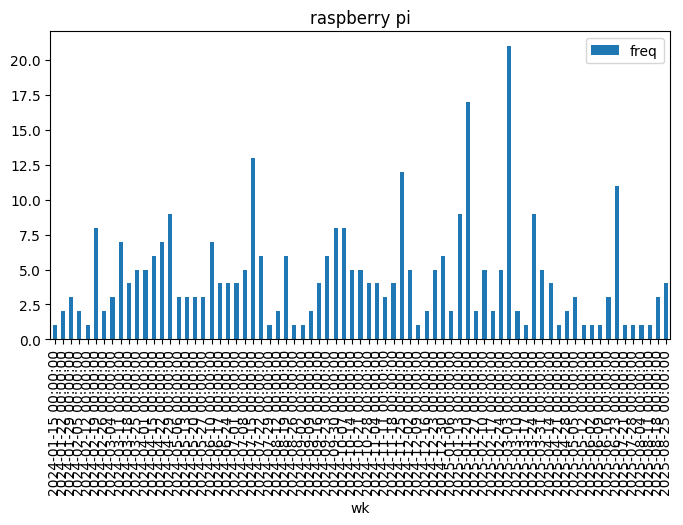

In [32]:
bigram_to_plot = "raspberry pi"   # 👈 change this to your chosen bigram

df = con.execute(f"""
    SELECT date_trunc('week', ts) AS wk, COUNT(*) AS freq
    FROM curated.search_bigrams
    WHERE bigram = '{bigram_to_plot}'
    GROUP BY 1
    ORDER BY wk;
""").fetchdf()

df.plot(x='wk', y='freq', kind='bar', figsize=(8,4), title=bigram_to_plot)


<Axes: title={'center': "Weekly searches for 'home assistant'"}, xlabel='wk'>

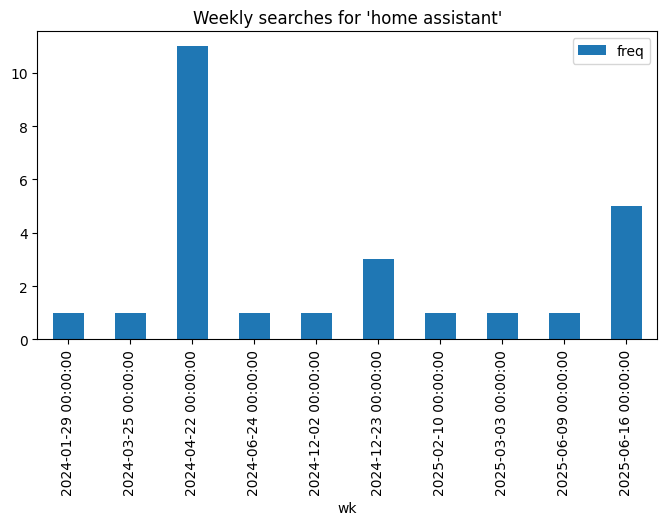

In [35]:
bigram_to_plot = "home assistant"

df = con.execute(f"""
    SELECT date_trunc('week', ts) AS wk, COUNT(*) AS freq
    FROM curated.search_bigrams
    WHERE bigram = '{bigram_to_plot}'
    GROUP BY 1
    ORDER BY wk;
""").fetchdf()

df.plot(x='wk', y='freq', kind='bar', figsize=(8,4), title=f"Weekly searches for '{bigram_to_plot}'")


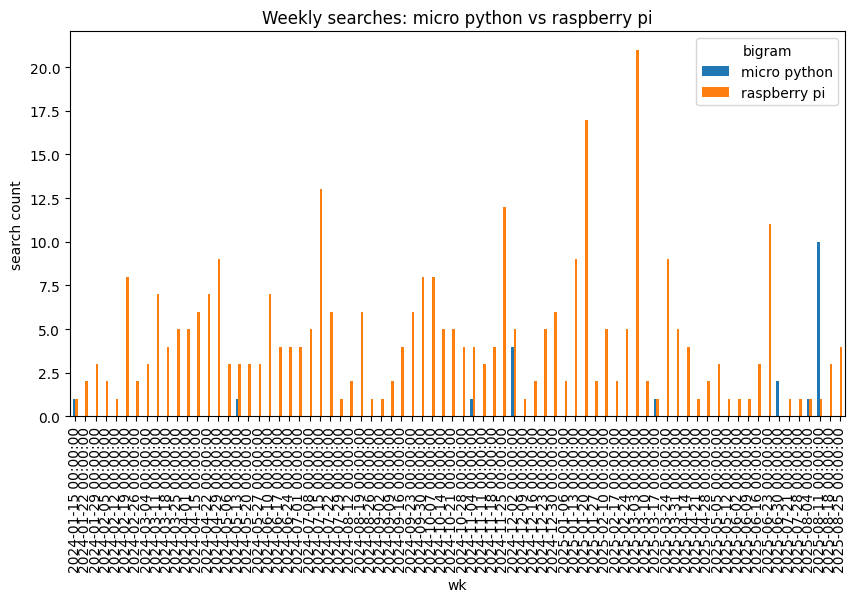

In [36]:
phrases = ["micro python", "raspberry pi"]

df = con.execute(f"""
    SELECT 
        date_trunc('week', ts) AS wk,
        bigram,
        COUNT(*) AS freq
    FROM curated.search_bigrams
    WHERE bigram IN ({','.join(["'" + p + "'" for p in phrases])})
    GROUP BY 1,2
    ORDER BY wk, bigram;
""").fetchdf()

import matplotlib.pyplot as plt

pivoted = df.pivot(index='wk', columns='bigram', values='freq').fillna(0)
pivoted.plot(kind='bar', figsize=(10,5), title="Weekly searches: micro python vs raspberry pi")
plt.ylabel("search count")
plt.show()


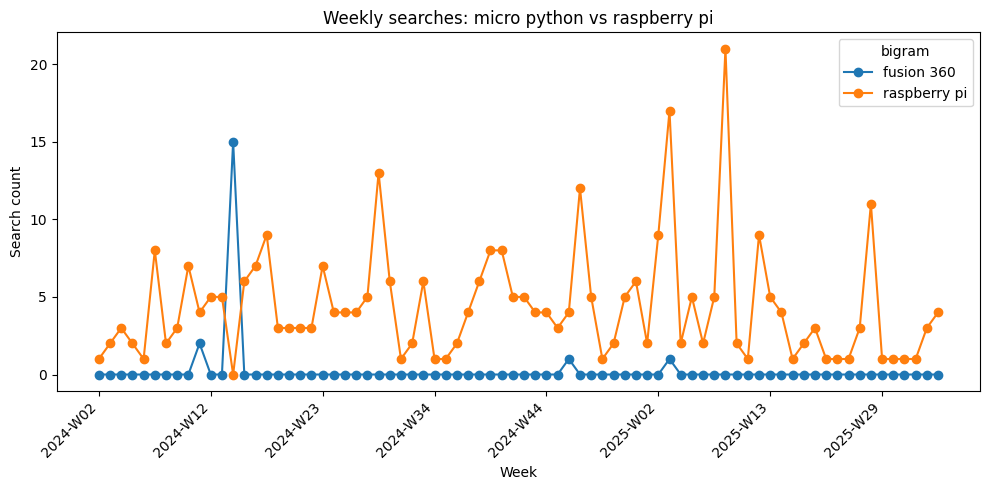

In [40]:
import matplotlib.pyplot as plt

phrases = ["fusion 360", "raspberry pi"]

df = con.execute(f"""
    SELECT 
        date_trunc('week', ts) AS wk,
        bigram,
        COUNT(*) AS freq
    FROM curated.search_bigrams
    WHERE bigram IN ({','.join(["'" + p + "'" for p in phrases])})
    GROUP BY 1,2
    ORDER BY wk, bigram;
""").fetchdf()

# Pivot into wide format: each phrase gets its own column
pivoted = df.pivot(index='wk', columns='bigram', values='freq').fillna(0)

# Format index for nicer x-axis labels (year-week)
pivoted.index = pivoted.index.strftime("%Y-W%U")

# Plot as line chart
pivoted.plot(kind='line', marker='o', figsize=(10,5))
plt.title("Weekly searches: micro python vs raspberry pi")
plt.xlabel("Week")
plt.ylabel("Search count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


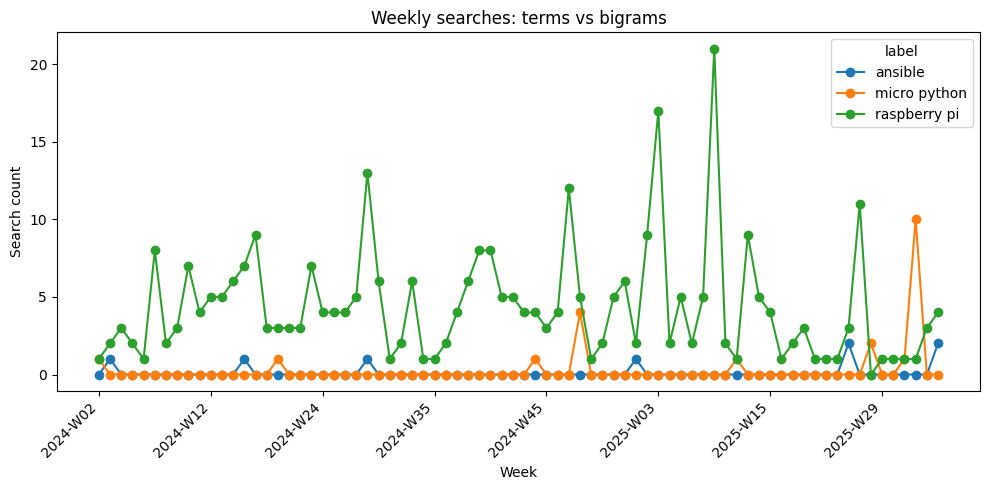

In [81]:
import matplotlib.pyplot as plt

# terms and bigrams you want to track
terms = ["ansible"]
bigrams = ["raspberry pi", "micro python"]

# build SQL
term_sql = f"""
    SELECT date_trunc('week', ts) AS wk,
           term AS label,
           COUNT(*) AS freq
    FROM curated.search_terms
    WHERE term IN ({','.join(["'" + t + "'" for t in terms])})
    GROUP BY 1,2
"""

bigram_sql = f"""
    SELECT date_trunc('week', ts) AS wk,
           bigram AS label,
           COUNT(*) AS freq
    FROM curated.search_bigrams
    WHERE bigram IN ({','.join(["'" + b + "'" for b in bigrams])})
    GROUP BY 1,2
"""

query = f"""
    {term_sql}
    UNION ALL
    {bigram_sql}
    ORDER BY wk, label
"""

df = con.execute(query).fetchdf()

# Pivot so each label has its own column
pivoted = df.pivot(index='wk', columns='label', values='freq').fillna(0)

# Format weeks nicely
pivoted.index = pivoted.index.strftime("%Y-W%U")

# Plot
pivoted.plot(kind='line', marker='o', figsize=(10,5))
plt.title("Weekly searches: terms vs bigrams")
plt.xlabel("Week")
plt.ylabel("Search count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


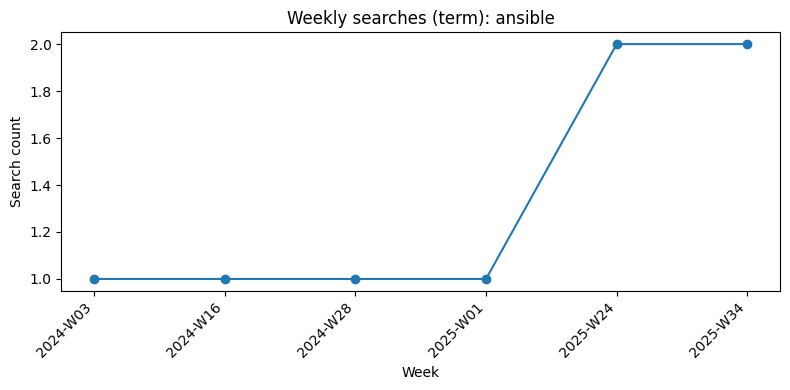

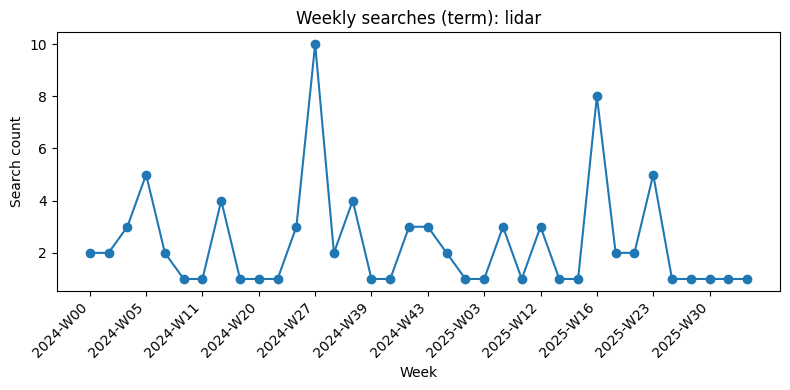

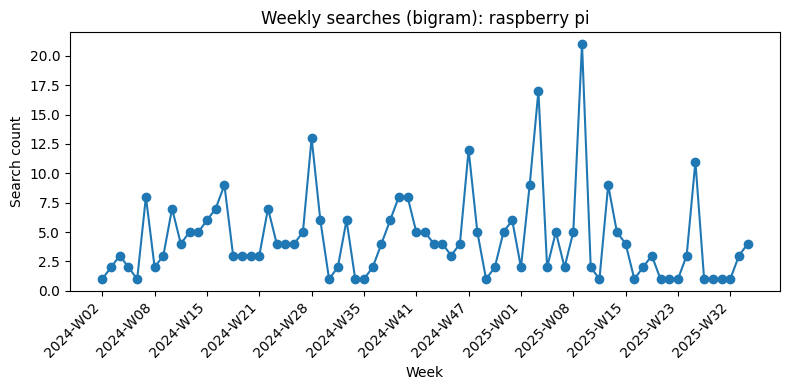

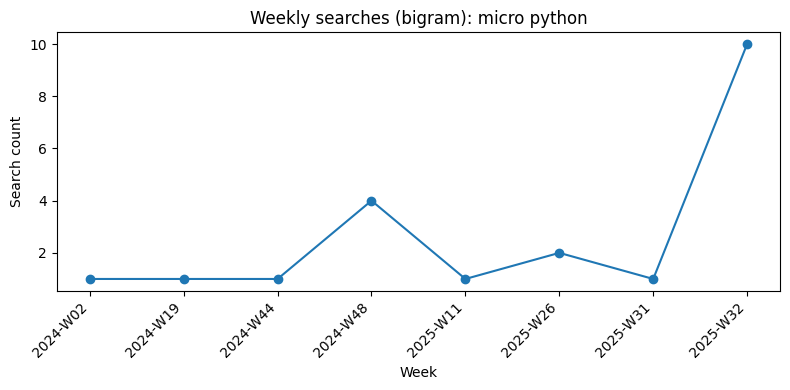

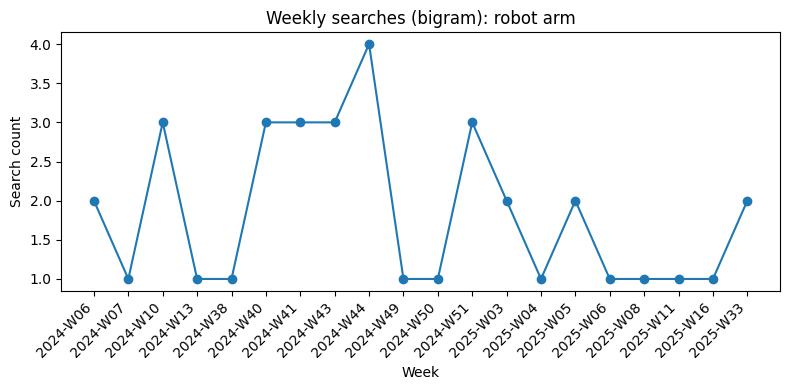

In [42]:
import matplotlib.pyplot as plt

# 🔧 Edit these lists
terms   = ["ansible", "lidar"]
bigrams = ["raspberry pi", "micro python", "robot arm"]

def weekly_series_for(label, table, col):
    q = f"""
        SELECT date_trunc('week', ts) AS wk, COUNT(*) AS freq
        FROM {table}
        WHERE {col} = ?
        GROUP BY 1
        ORDER BY wk
    """
    df = con.execute(q, [label]).fetchdf()
    if len(df) == 0:
        return None
    # Format week label like 2025-W35
    df["wk_label"] = df["wk"].dt.strftime("%Y-W%U")
    return df

def plot_single(df, title):
    # One chart per label (no subplots)
    plt.figure(figsize=(8,4))
    plt.plot(df["wk_label"], df["freq"], marker="o")
    plt.title(title)
    plt.xlabel("Week")
    plt.ylabel("Search count")
    # Make x-axis readable: show at most ~12 ticks
    step = max(1, len(df) // 12)
    plt.xticks(df["wk_label"][::step], rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# 🔁 Make a chart for each term (single word)
for t in terms:
    df = weekly_series_for(t, "curated.search_terms", "term")
    if df is None:
        print(f"(no data for term: {t})")
        continue
    plot_single(df, f"Weekly searches (term): {t}")

# 🔁 Make a chart for each bigram (two-word phrase)
for b in bigrams:
    df = weekly_series_for(b, "curated.search_bigrams", "bigram")
    if df is None:
        print(f"(no data for bigram: {b})")
        continue
    plot_single(df, f"Weekly searches (bigram): {b}")


In [51]:
# Totals.csv  → daily views time series
con.execute("""
CREATE OR REPLACE TABLE raw.youtube_totals AS
SELECT *, filename AS source_file
FROM read_csv_auto('data/youtube/*Totals*.csv', filename=true, normalize_names=true);
""")

# Table data.csv → per-video summary (titles, views, etc.)
con.execute("""
CREATE OR REPLACE TABLE raw.youtube_table AS
SELECT *, filename AS source_file
FROM read_csv_auto('data/youtube/*Table*.csv', filename=true, normalize_names=true);
""")

# Chart data.csv → the chart’s granular rows (often per-day or per-video slices)
con.execute("""
CREATE OR REPLACE TABLE raw.youtube_chart AS
SELECT *, filename AS source_file
FROM read_csv_auto('data/youtube/*Chart*.csv', filename=true, normalize_names=true);
""")

# Quick counts
con.execute("""
SELECT 'totals' AS src, COUNT(*) AS rows FROM raw.youtube_totals
UNION ALL
SELECT 'table' , COUNT(*) FROM raw.youtube_table
UNION ALL
SELECT 'chart' , COUNT(*) FROM raw.youtube_chart;
""").fetchdf()


,src,rows
0,totals,6583
1,table,502
2,chart,32915


In [53]:
import glob, duckdb

# 1) find your "Table data" export
table_paths = glob.glob("data/youtube/*Table*.csv")
assert table_paths, "No file matching data/youtube/*Table*.csv"
path = table_paths[0]
print("Using:", path)

# 2) try a few delimiter/encoding combos and pick the best
candidates = [
    { "delim": ",",  "encoding": "utf-8"     },
    { "delim": ",",  "encoding": "utf-8-sig" },
    { "delim": "\t", "encoding": "utf-16"    },
    { "delim": "\t", "encoding": "utf-16le"  },
    { "delim": ";",  "encoding": "utf-8"     },
]

def try_headers(d,e):
    q = f"""
      SELECT * FROM read_csv('{path}',
         header=true, delim='{d}', encoding='{e}', normalize_names=true)
      LIMIT 0;
    """
    try:
        cols = list(con.execute(q).fetchdf().columns)
        return cols
    except Exception as ex:
        return None

scores = []
for opt in candidates:
    cols = try_headers(opt["delim"], opt["encoding"])
    if not cols:
        scores.append((opt, 0, []))
        continue
    cl = [c.lower() for c in cols]
    score = 0
    if any("title" in c or "video" in c for c in cl): score += 2
    if any("views" in c for c in cl):                 score += 2
    if len(cols) >= 5:                                 score += 1
    scores.append((opt, score, cols))

# pick the best-scoring option
best = sorted(scores, key=lambda t: t[1], reverse=True)[0]
opt, score, cols = best
print("Chosen ->", opt, "| columns:", cols[:8], "..." if len(cols)>8 else "")

# 3) (re)ingest the table with the chosen settings
con.execute(f"""
CREATE OR REPLACE TABLE raw.youtube_table AS
SELECT *, filename AS source_file
FROM read_csv('{path}',
    header=true, delim='{opt["delim"]}', encoding='{opt["encoding"]}', normalize_names=true, filename=true);
""")

# 4) standardize to curated.youtube_videos (title / views / published_at)
def q(col: str) -> str: return '"' + col.replace('"','""') + '"'
cols_all = [r[1] for r in con.execute("PRAGMA table_info('raw.youtube_table')").fetchall()]
lower = {c.lower(): c for c in cols_all}

title_cands = ["video_title","title","name","video"]
views_cands = ["views","view_count","lifetime_views","views_lifetime","views_last_28_days"]
date_cands  = ["published_date","publish_date","video_publish_time","video_published_date","date","creation_date"]

def pick(cands):
    for c in cands:
        if c in lower: return lower[c]
    return None

title_col = pick(title_cands)
views_col = pick(views_cands)
date_col  = pick(date_cands)

print("Detected columns:", title_col, views_col, date_col)

assert title_col and views_col, f"Still missing title/views. Columns: {cols_all}"

sql = f"""
CREATE OR REPLACE TABLE curated.youtube_videos AS
SELECT
  {q(title_col)} AS title,
  TRY_CAST({q(views_col)} AS BIGINT) AS views,
  { (f"TRY_CAST({q(date_col)} AS DATE)" if date_col else "NULL::DATE") } AS published_at,
  source_file
FROM raw.youtube_table
WHERE {q(title_col)} IS NOT NULL;
"""
con.execute(sql)

print("Rows in curated.youtube_videos:",
      con.execute("SELECT COUNT(*) FROM curated.youtube_videos;").fetchone()[0])
print(con.execute("SELECT * FROM curated.youtube_videos LIMIT 5;").fetchdf())


Using: data/youtube/Table data.csv
Chosen -> {'delim': ';', 'encoding': 'utf-8'} | columns: ['contentvideo_titlevideo_publish_timedurationviewswatch_time_hourssubscribersestimated_revenue_gbpimpressionsimpressions_clickthrough_rate'] 
Detected columns: None None None


AssertionError: Still missing title/views. Columns: ['contentvideo_titlevideo_publish_timedurationviewswatch_time_hourssubscribersestimated_revenue_gbpimpressionsimpressions_clickthrough_rate', 'filename', 'source_file']

In [ ]:
import glob

# 1) Pick your "Table data" export
paths = glob.glob("data/youtube/*Table*.csv")
assert paths, "No file matching data/youtube/*Table*.csv"
path = paths[0]
print("Using:", path)

# 2) Try a few (encoding, delimiter) combos and pick the best
candidates = [
    ("utf-16le", "\t"),
    ("utf-16",   "\t"),
    ("utf-8-sig", ","),
    ("utf-8",    ","),
    ("utf-8-sig","\t"),
    ("utf-8",    "\t"),
    ("utf-16le", ","),
    ("utf-16",   ","),
]

best = None
best_cols = []
best_score = -1
for enc, delim in candidates:
    try:
        q = """
            SELECT * FROM read_csv(?, 
                header=true, delim=?, encoding=?,
                normalize_names=true, filename=true,
                strict_mode=false, ignore_errors=true, null_padding=true,
                quote='"', escape='"')
            LIMIT 0;
        """
        cols = list(con.execute(q, [path, delim, enc]).fetchdf().columns)
        cl = [c.lower() for c in cols]
        score = 0
        if any(("title" in c) or ("video" in c) for c in cl): score += 2
        if any("views" in c for c in cl):                      score += 2
        if len(cols) >= 5:                                     score += 1
        label = "TAB" if delim == "\t" else delim
        print("OK enc={}, delim={} -> {}".format(enc, label, cols[:8]))
        if score > best_score:
            best_score, best, best_cols = score, (enc, delim), cols
    except Exception as e:
        label = "TAB" if delim == "\t" else delim
        print("FAIL enc={}, delim={}: {}".format(enc, label, e))

print("\nBest guess:", best, "| Columns:", best_cols[:12])

# 3) Ingest with the best combo
if best is None:
    raise RuntimeError("Could not read Table data.csv with known combos.")
enc, delim = best
con.execute("""
CREATE OR REPLACE TABLE raw.youtube_table AS
SELECT *, filename AS source_file
FROM read_csv(?, 
    header=true, delim=?, encoding=?,
    normalize_names=true, filename=true,
    strict_mode=false, ignore_errors=true, null_padding=true,
    quote='"', escape='"');
""", [path, delim, enc])

print("Rows in raw.youtube_table:",
      con.execute("SELECT COUNT(*) FROM raw.youtube_table;").fetchone()[0])
print(con.execute("PRAGMA table_info('raw.youtube_table');").fetchdf())


In [59]:
def q(col: str): 
    return '"' + col.replace('"','""') + '"'

cols_all = [r[1] for r in con.execute("PRAGMA table_info('raw.youtube_table')").fetchall()]
lower = {c.lower(): c for c in cols_all}

title_col = next((lower[k] for k in ["video_title","title","video","name"] if k in lower), None)
views_col = next((lower[k] for k in ["views","view_count","lifetime_views","views_lifetime","views_last_28_days"] if k in lower), None)
date_col  = next((lower[k] for k in ["video_publish_time","published_date","publish_date","video_published_date","date","creation_date"] if k in lower), None)

print("Detected:", dict(title=title_col, views=views_col, date=date_col))

if not (title_col and views_col):
    raise RuntimeError("Still missing title/views. Columns: {}".format(cols_all))

con.execute(f"""
CREATE OR REPLACE TABLE curated.youtube_videos AS
SELECT
  {q(title_col)} AS title,
  TRY_CAST({q(views_col)} AS BIGINT) AS views,
  {(f"TRY_CAST({q(date_col)} AS DATE)" if date_col else "NULL::DATE")} AS published_at,
  source_file
FROM raw.youtube_table
WHERE {q(title_col)} IS NOT NULL;
""")

print("Rows in curated.youtube_videos:",
      con.execute("SELECT COUNT(*) FROM curated.youtube_videos;").fetchone()[0])


Detected: {'title': 'video_title', 'views': None, 'date': 'video_publish_time'}


RuntimeError: Still missing title/views. Columns: ['_content', 'video_title', 'video_publish_time', 'duration', '_views', 'watch_time_hours', 'subscribers', 'estimated_revenue_gbp', 'impressions', 'impressions_clickthrough_rate', 'filename', 'source_file']

In [60]:
# Build curated.youtube_videos from your detected columns
con.execute("""
CREATE OR REPLACE TABLE curated.youtube_videos AS
SELECT
  video_title                            AS title,
  TRY_CAST(_views AS BIGINT)             AS views,
  TRY_CAST(video_publish_time AS TIMESTAMP) AS published_at,
  source_file
FROM raw.youtube_table
WHERE video_title IS NOT NULL;
""")

# Quick checks
con.execute("SELECT COUNT(*) FROM curated.youtube_videos;").fetchone()[0]
con.execute("SELECT * FROM curated.youtube_videos LIMIT 5;").fetchdf()


,title,views,published_at,source_file
0,Is the new Raspberry Pi AI Kit better than Goo...,135741,NaT,data/youtube/Table data.csv
1,Build Your Own AI Assistant Part 1 - Creating ...,121848,NaT,data/youtube/Table data.csv
2,Control Arduino with Python using Firmata / P...,88886,NaT,data/youtube/Table data.csv
3,How to Map with LiDAR - using a Raspberry Pi Z...,65665,NaT,data/youtube/Table data.csv
4,Creating a Supercomputer with a Raspberry Pi 5...,60847,NaT,data/youtube/Table data.csv


In [61]:
con.execute("SELECT COUNT(*) FROM curated.youtube_videos;").fetchone()[0]

500

In [62]:
pageviews_url = "https://page_count.kevsrobots.com/all-visits"  # 👈 replace me

# read array-of-objects OR NDJSON; httpfs is already loaded
con.execute("""
CREATE OR REPLACE TABLE raw.pageviews AS
SELECT * FROM read_json_auto(?);
""", [pageviews_url])

# See what columns we got
con.execute("PRAGMA table_info('raw.pageviews');").fetchdf()


HTTPException: HTTP Error: HTTP GET error: Content-Length from server mismatches requested range, server may not support range requests.

In [64]:
import os
from urllib.request import urlopen, Request
import duckdb

# 👇 your page-views JSON endpoint
pageviews_url = "http://page_count.kevsrobots.com/all-visits"

# Save locally
os.makedirs("data/web", exist_ok=True)
local_json = "data/web/pageviews.json"

req = Request(pageviews_url, headers={"User-Agent": "Mozilla/5.0"})
with urlopen(req, timeout=60) as r, open(local_json, "wb") as f:
    f.write(r.read())

# Ingest into DuckDB (array or NDJSON both fine)
con.execute("""
CREATE OR REPLACE TABLE raw.pageviews AS
SELECT * FROM read_json_auto(?);
""", [local_json])

# --- Standardize -> curated.web_view_daily(day, path, views) ---

def q(col: str) -> str:
    return '"' + col.replace('"','""') + '"'

cols_info = con.execute("PRAGMA table_info('raw.pageviews');").fetchall()
cols = [c[1] for c in cols_info]
lower = {c.lower(): c for c in cols}

date_cands  = ["date","day","timestamp","ts","time"]
path_cands  = ["path","url","uri","page","endpoint","pathname"]
views_cands = ["views","pageviews","count","hits","visitors","sessions"]

def pick(cands):
    for c in cands:
        if c in lower: return lower[c]
    return None

date_col  = pick(date_cands)
path_col  = pick(path_cands)
views_col = pick(views_cands)

if date_col is None:
    raise RuntimeError(f"Couldn't find a date-like column in {cols}")

day_expr   = f"COALESCE(TRY_CAST({q(date_col)} AS DATE), CAST(TRY_CAST({q(date_col)} AS TIMESTAMP) AS DATE))"
path_expr  = (q(path_col) if path_col else "NULL::VARCHAR")
views_expr = (f"TRY_CAST({q(views_col)} AS BIGINT)" if views_col else "1::BIGINT")

# build the curated table
con.execute(f"""
CREATE OR REPLACE TABLE curated.web_view_daily AS
SELECT
  {day_expr} AS day,
  {path_expr} AS path,
  {views_expr} AS views
FROM raw.pageviews
WHERE {q(date_col)} IS NOT NULL;
""")

# aggregate to daily totals per path
con.execute("""
CREATE OR REPLACE TABLE curated.web_view_daily AS
SELECT day, path, SUM(views) AS views
FROM curated.web_view_daily
WHERE day IS NOT NULL
GROUP BY 1,2;
""")

# quick checks
print("rows:", con.execute("SELECT COUNT(*) FROM curated.web_view_daily;").fetchone()[0])
display(con.execute("SELECT * FROM curated.web_view_daily ORDER BY day DESC, views DESC LIMIT 10;").fetchdf())


RuntimeError: Couldn't find a date-like column in ['visits', 'total_count']

In [65]:
# 1) Peek at the top-level row (optional)
display(con.execute("SELECT * FROM raw.pageviews LIMIT 1;").fetchdf())

# 2) Explode the `visits` array and extract fields
con.execute("""
CREATE OR REPLACE TABLE raw.pageviews_flat AS
WITH base AS (
  SELECT visits
  FROM raw.pageviews
  LIMIT 1
),
items AS (
  -- json_each() iterates the array; value = each JSON object
  SELECT value AS v
  FROM base, LATERAL json_each(base.visits)
),
picked AS (
  SELECT
    COALESCE(
      json_extract_string(v, '$.timestamp'),
      json_extract_string(v, '$.time'),
      json_extract_string(v, '$.date'),
      json_extract_string(v, '$.ts')
    )                                                     AS ts_txt,
    COALESCE(
      json_extract_string(v, '$.path'),
      json_extract_string(v, '$.url'),
      json_extract_string(v, '$.uri'),
      json_extract_string(v, '$.page'),
      json_extract_string(v, '$.endpoint'),
      json_extract_string(v, '$.pathname')
    )                                                     AS path_txt,
    COALESCE(
      TRY_CAST(json_extract(v, '$.views')  AS BIGINT),
      TRY_CAST(json_extract(v, '$.count')  AS BIGINT),
      TRY_CAST(json_extract(v, '$.hits')   AS BIGINT),
      TRY_CAST(json_extract(v, '$.visits') AS BIGINT),
      1::BIGINT
    )                                                     AS views
  FROM items
)
SELECT
  CAST(TRY_CAST(ts_txt AS TIMESTAMP) AS DATE) AS day,
  NULLIF(path_txt, '')                         AS path,
  views
FROM picked
WHERE ts_txt IS NOT NULL;
""")

# 3) Aggregate to daily totals per path
con.execute("""
CREATE OR REPLACE TABLE curated.web_view_daily AS
SELECT day, path, SUM(views) AS views
FROM raw.pageviews_flat
WHERE day IS NOT NULL
GROUP BY 1,2;
""")

# 4) Quick checks
print("rows:", con.execute("SELECT COUNT(*) FROM curated.web_view_daily;").fetchone()[0])
display(con.execute("SELECT * FROM curated.web_view_daily ORDER BY day DESC, views DESC LIMIT 10;").fetchdf())


,visits,total_count
0,[{'url': 'https://www.kevsrobots.com/blog/wood...,"39,848"


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

rows: 15902


,day,path,views
0,2025-09-01,https://www.kevsrobots.com/,38.0
1,2025-09-01,https://www.kevsrobots.com/blog/pico-projects....,19.0
2,2025-09-01,https://www.kevsrobots.com/blog/woodbot.html,13.0
3,2025-09-01,https://www.kevsrobots.com/blog/3d_papercraft....,9.0
4,2025-09-01,https://www.kevsrobots.com/projects/mini-rack/,9.0
5,2025-09-01,https://www.kevsrobots.com/blog/build-a-home-s...,9.0
6,2025-09-01,https://www.kevsrobots.com/blog/dynamic-dns.html,8.0
7,2025-09-01,https://www.kevsrobots.com/learn/pca9685/05_se...,8.0
8,2025-09-01,https://www.kevsrobots.com/blog/ollama,8.0
9,2025-09-01,https://www.kevsrobots.com/robots/,7.0


In [66]:
# Terms from page paths (weighted by views)
con.execute("""
CREATE OR REPLACE TABLE curated.web_terms AS
WITH cleaned AS (
  SELECT
    day,
    views,
    trim(regexp_replace(regexp_replace(lower(path), '[^a-z0-9]+',' ','g'),
                        '\\s+', ' ', 'g')) AS t
  FROM curated.web_view_daily
  WHERE path IS NOT NULL
),
tokens AS (
  SELECT day, views, unnest(string_split(t, ' ')) AS term
  FROM cleaned
)
SELECT day, term, SUM(views) AS views
FROM tokens
WHERE term <> '' AND length(term) >= 2
  AND term NOT IN (SELECT stop FROM curated.stopwords)
GROUP BY 1,2;
""")

# Bigrams from page paths (weighted by views)
con.execute("""
CREATE OR REPLACE TABLE curated.web_bigrams AS
WITH cleaned AS (
  SELECT
    day,
    views,
    trim(regexp_replace(regexp_replace(lower(path), '[^a-z0-9]+',' ','g'),
                        '\\s+', ' ', 'g')) AS t
  FROM curated.web_view_daily
  WHERE path IS NOT NULL
),
parts AS (
  SELECT day, views, string_split(t, ' ') AS tokens
  FROM cleaned
),
idx AS (
  SELECT p.day, p.views, p.tokens, gs.i
  FROM parts p,
  LATERAL (SELECT * FROM generate_series(1, array_length(p.tokens) - 1)) AS gs(i)
  WHERE array_length(tokens) >= 2
),
b AS (
  SELECT day, views, tokens[i] AS t1, tokens[i+1] AS t2
  FROM idx
)
SELECT day, (t1 || ' ' || t2) AS bigram, SUM(views) AS views
FROM b
WHERE length(t1) >= 2 AND length(t2) >= 2
  AND t1 NOT IN (SELECT stop FROM curated.stopwords)
  AND t2 NOT IN (SELECT stop FROM curated.stopwords)
GROUP BY 1,2;
""")


In [67]:
# Weekly sums
con.execute("""
CREATE OR REPLACE TABLE curated.web_bigram_weekly AS
SELECT date_trunc('week', day) AS wk, bigram, SUM(views) AS wviews
FROM curated.web_bigrams
GROUP BY 1,2;
""")

# Week-over-week risers (web bigrams)
con.execute("""
WITH growth AS (
  SELECT
    bigram, wk, wviews,
    LAG(wviews) OVER (PARTITION BY bigram ORDER BY wk) AS prev
  FROM curated.web_bigram_weekly
)
SELECT
  bigram, wk, wviews, prev,
  (wviews - prev) AS abs_change,
  CASE WHEN prev IS NULL OR prev = 0 THEN NULL
       ELSE ROUND((wviews - prev) * 100.0 / prev, 1)
  END AS pct_change
FROM growth
WHERE prev IS NOT NULL
ORDER BY pct_change DESC
LIMIT 20;
""").fetchdf()


,bigram,wk,wviews,prev,abs_change,pct_change
0,4000 learn,2025-08-18,174.0,1.0,173.0,17300.0
1,4000 all,2025-08-25,20.0,1.0,19.0,1900.0
2,13 wheel,2025-08-25,16.0,1.0,15.0,1500.0
3,fusion360 13,2025-08-25,16.0,1.0,15.0,1500.0
4,smars quad,2025-08-04,77.0,5.0,72.0,1440.0
5,fusion360 01,2025-08-18,15.0,1.0,14.0,1400.0
6,01 base,2025-08-18,15.0,1.0,14.0,1400.0
7,wheel html,2025-08-25,15.0,1.0,14.0,1400.0
8,building html,2025-08-25,12.0,1.0,11.0,1100.0
9,16 cut,2025-08-25,12.0,1.0,11.0,1100.0


In [73]:
df = con.execute("""
WITH sb AS (
  SELECT date_trunc('week', day) AS wk, bigram, SUM(freq) AS wfreq
  FROM curated.bigram_daily
  GROUP BY 1,2
),
s_growth AS (
  SELECT bigram, wk, wfreq,
         LAG(wfreq) OVER (PARTITION BY bigram ORDER BY wk) AS prev
  FROM sb
),
s_risers AS (
  SELECT bigram, wk, wfreq, prev,
         (wfreq - prev) AS s_abs_change,
         CASE WHEN prev IS NULL OR prev = 0 THEN NULL
              ELSE (wfreq - prev) * 1.0 / prev
         END AS s_pct_change
  FROM s_growth
  WHERE prev IS NOT NULL
),

wb AS (
  SELECT wk, bigram, SUM(wviews) AS wviews
  FROM curated.web_bigram_weekly
  GROUP BY 1,2
),
w_growth AS (
  SELECT bigram, wk, wviews,
         LAG(wviews) OVER (PARTITION BY bigram ORDER BY wk) AS prev
  FROM wb
),
w_risers AS (
  SELECT bigram, wk, wviews, prev,
         (wviews - prev) AS w_abs_change,
         CASE WHEN prev IS NULL OR prev = 0 THEN NULL
              ELSE (wviews - prev) * 1.0 / prev
         END AS w_pct_change
  FROM w_growth
  WHERE prev IS NOT NULL
)

SELECT
  s.bigram,
  s.wk AS wk,
  ROUND(s.s_pct_change * 100, 1) AS search_pct_up,
  COALESCE(ROUND(w.w_pct_change * 100, 1), 0) AS web_pct_up,
  s.s_abs_change,
  COALESCE(w.w_abs_change, 0) AS web_abs_change
FROM s_risers s
LEFT JOIN w_risers w
  ON s.bigram = w.bigram AND s.wk = w.wk
WHERE s.s_pct_change > 0
  AND (w.w_pct_change IS NULL OR w.w_pct_change <= 0.10)
ORDER BY search_pct_up DESC, s_abs_change DESC
LIMIT 25;
""").fetchdf()

print(df)


            bigram         wk  search_pct_up  web_pct_up  s_abs_change   
0   pico bluetooth 2024-12-30         1700.0         0.0          17.0  \
1       web server 2025-05-26         1400.0         0.0          14.0   
2   home assistant 2024-04-22         1000.0         0.0          10.0   
3     micro python 2025-08-11          900.0         0.0           9.0   
4     raspberry pi 2025-03-24          800.0         0.0           8.0   
5        learn ros 2024-11-11          700.0         0.0           7.0   
6     raspberry pi 2024-02-19          700.0         0.0           7.0   
7       fusion 360 2024-04-08          650.0         0.0          13.0   
8      smars robot 2024-02-12          600.0         0.0           6.0   
9      normal form 2024-04-29          500.0         0.0           5.0   
10        node red 2025-07-14          500.0         0.0           5.0   
11       learn ros 2024-08-19          500.0         0.0           5.0   
12       qr reader 2024-08-12         

In [75]:
import matplotlib.pyplot as plt

# 👈 Pick a phrase from your table (e.g. "pico bluetooth", "micro python", "web server")
phrase = "pico bluetooth"

# 1) Weekly series for Search / Web / YouTube
df = con.execute("""
WITH s AS (
  SELECT date_trunc('week', ts) AS wk, COUNT(*) AS search_freq
  FROM curated.search_bigrams WHERE bigram = ?
  GROUP BY 1
),
w AS (
  SELECT date_trunc('week', day) AS wk, SUM(views) AS web_views
  FROM curated.web_bigrams WHERE bigram = ?
  GROUP BY 1
),
y AS (
  SELECT date_trunc('week', published_at) AS wk, COUNT(*) AS yt_titles
  FROM curated.youtube_bigrams WHERE bigram = ?
  GROUP BY 1
)
SELECT
  COALESCE(s.wk, w.wk, y.wk) AS wk,
  COALESCE(search_freq, 0)   AS search_freq,
  COALESCE(web_views, 0)     AS web_views,
  COALESCE(yt_titles, 0)     AS yt_titles
FROM s
FULL OUTER JOIN w ON s.wk = w.wk
FULL OUTER JOIN y ON COALESCE(s.wk, w.wk) = y.wk
ORDER BY wk;
""", [phrase, phrase, phrase]).fetchdf()

# 2) Quick WoW in Python (last two weeks present)
wow = None
if len(df) >= 2:
    last2 = df.tail(2).reset_index(drop=True)
    wow = {
        "search_this": int(last2.loc[1,"search_freq"]),
        "search_last": int(last2.loc[0,"search_freq"]),
        "web_this":    int(last2.loc[1,"web_views"]),
        "web_last":    int(last2.loc[0,"web_views"]),
        "yt_this":     int(last2.loc[1,"yt_titles"]),
        "yt_last":     int(last2.loc[0,"yt_titles"]),
    }
    wow["search_abs_change"] = wow["search_this"] - wow["search_last"]
    wow["web_abs_change"]    = wow["web_this"]    - wow["web_last"]
    wow["yt_abs_change"]     = wow["yt_this"]     - wow["yt_last"]

# 3) Plot (one chart)
if not df.empty:
    x = df['wk'].dt.strftime("%Y-W%U")
    plt.figure(figsize=(10,5))
    plt.plot(x, df['search_freq'], marker='o', label='Search freq')
    plt.plot(x, df['web_views'],   marker='o', label='Web views (weighted)')
    plt.plot(x, df['yt_titles'],   marker='o', label='YouTube titles count')
    plt.title(f"Weekly trend for '{phrase}'")
    plt.xlabel("Week"); plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

# 4) Top matching pages on your site
parts = phrase.split()
t1 = parts[0]
t2 = parts[1] if len(parts) > 1 else parts[0]
pages = con.execute("""
SELECT day, path, views
FROM curated.web_view_daily
WHERE lower(path) LIKE '%' || ? || '%'
  AND lower(path) LIKE '%' || ? || '%'
ORDER BY views DESC
LIMIT 15;
""", [t1.lower(), t2.lower()]).fetchdf()

df, wow, pages


CatalogException: Catalog Error: Table with name youtube_bigrams does not exist!
Did you mean "youtube_videos"?

LINE 14:   FROM curated.youtube_bigrams WHERE bigram = ?
                ^

In [76]:
con.execute("""
CREATE OR REPLACE TABLE curated.youtube_terms AS
WITH cleaned AS (
  SELECT
    published_at,
    source_file,
    trim(regexp_replace(regexp_replace(lower(title), '[^a-z0-9]+',' ','g'),
                        '\\s+', ' ', 'g')) AS t
  FROM curated.youtube_videos
  WHERE title IS NOT NULL
),
tokens AS (
  SELECT published_at, source_file, unnest(string_split(t, ' ')) AS term
  FROM cleaned
)
SELECT published_at, source_file, term
FROM tokens
WHERE term <> '' AND length(term) >= 2
  AND term NOT IN (SELECT stop FROM curated.stopwords);
""")


In [77]:
con.execute("""
CREATE OR REPLACE TABLE curated.youtube_bigrams AS
WITH cleaned AS (
  SELECT
    published_at,
    source_file,
    trim(regexp_replace(regexp_replace(lower(title), '[^a-z0-9]+',' ','g'),
                        '\\s+', ' ', 'g')) AS t
  FROM curated.youtube_videos
  WHERE title IS NOT NULL
),
parts AS (
  SELECT published_at, source_file, string_split(t, ' ') AS tokens
  FROM cleaned
),
idx AS (
  SELECT
    p.published_at, p.source_file, p.tokens, gs.i
  FROM parts p,
  LATERAL (SELECT * FROM generate_series(1, array_length(p.tokens) - 1)) AS gs(i)
  WHERE array_length(tokens) >= 2
),
b AS (
  SELECT
    published_at,
    source_file,
    tokens[i]     AS t1,
    tokens[i + 1] AS t2
  FROM idx
)
SELECT
  published_at,
  source_file,
  t1 || ' ' || t2 AS bigram
FROM b
WHERE length(t1) >= 2 AND length(t2) >= 2
  AND t1 NOT IN (SELECT stop FROM curated.stopwords)
  AND t2 NOT IN (SELECT stop FROM curated.stopwords);
""")


In [78]:
con.execute("""
CREATE OR REPLACE TABLE curated.youtube_bigram_weekly AS
SELECT date_trunc('week', published_at) AS wk, bigram, COUNT(*) AS freq
FROM curated.youtube_bigrams
WHERE published_at IS NOT NULL
GROUP BY 1,2;
""")


In [79]:
con.execute("SELECT COUNT(*) FROM curated.youtube_bigrams;").fetchone()[0]


1998

In [80]:
phrase = "pico bluetooth"  # or any bigram from your gaps table


In [89]:
# === DRILL-DOWN v2 (robust to NaNs/types): Search vs Web vs YouTube =========
import re
import pandas as pd
import matplotlib.pyplot as plt

def drilldown(phrase: str, top_pages: int = 15):
    phrase = "" if phrase is None else str(phrase)

    # 1) Weekly series for Search / Web / YouTube
    series_sql = """
    WITH s AS (
      SELECT date_trunc('week', ts) AS wk, COUNT(*) AS search_freq
      FROM curated.search_bigrams WHERE bigram = ?
      GROUP BY 1
    ),
    w AS (
      SELECT date_trunc('week', day) AS wk, SUM(views) AS web_views
      FROM curated.web_bigrams WHERE bigram = ?
      GROUP BY 1
    ),
    y AS (
      SELECT date_trunc('week', published_at) AS wk, COUNT(*) AS yt_titles
      FROM curated.youtube_bigrams WHERE bigram = ?
      GROUP BY 1
    ),
    weeks AS (
      SELECT wk FROM s
      UNION
      SELECT wk FROM w
      UNION
      SELECT wk FROM y
    )
    SELECT
      weeks.wk,
      COALESCE(s.search_freq, 0) AS search_freq,
      COALESCE(w.web_views,   0) AS web_views,
      COALESCE(y.yt_titles,   0) AS yt_titles
    FROM weeks
    LEFT JOIN s ON s.wk = weeks.wk
    LEFT JOIN w ON w.wk = weeks.wk
    LEFT JOIN y ON y.wk = weeks.wk
    ORDER BY weeks.wk;
    """
    df = con.execute(series_sql, [phrase, phrase, phrase]).fetchdf()

    # Coerce numerics & guard missing weeks
    if not df.empty:
        for col in ["search_freq", "web_views", "yt_titles"]:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col]).fillna(0).astype(int)

    # 2) Quick WoW (last two non-empty rows)
    wow = None
    if len(df) >= 2:
        last2 = df.tail(2).reset_index(drop=True)
        wow = {
            "search_this": int(last2.loc[1, "search_freq"]),
            "search_last": int(last2.loc[0, "search_freq"]),
            "web_this":    int(last2.loc[1, "web_views"]),
            "web_last":    int(last2.loc[0, "web_views"]),
            "yt_this":     int(last2.loc[1, "yt_titles"]),
            "yt_last":     int(last2.loc[0, "yt_titles"]),
        }
        wow["search_abs_change"] = wow["search_this"] - wow["search_last"]
        wow["web_abs_change"]    = wow["web_this"]    - wow["web_last"]
        wow["yt_abs_change"]     = wow["yt_this"]     - wow["yt_last"]

    # 3) Plot with numeric x positions and string labels (avoids dtype issues)
    if not df.empty:
        labels = [w.strftime("%Y-W%U") if pd.notnull(w) else "" for w in df["wk"]]
        xpos = list(range(len(labels)))
        plt.figure(figsize=(10,5))
        plt.plot(xpos, df["search_freq"], marker="o", label="Search freq")
        plt.plot(xpos, df["web_views"],   marker="o", label="Web views (weighted)")
        plt.plot(xpos, df["yt_titles"],   marker="o", label="YouTube titles count")
        plt.title(f"Weekly trend for '{phrase}'")
        plt.xlabel("Week"); plt.ylabel("Count")
        step = max(1, len(xpos)//12)
        plt.xticks(xpos[::step], [labels[i] for i in xpos[::step]], rotation=45, ha="right")
        plt.legend()
        plt.tight_layout()
        plt.show()

    # 4) Top matching pages on your site (AND all words in phrase)
    tokens = [t for t in re.findall(r"[a-z0-9]+", phrase.lower()) if t]
    if not tokens:
        pages = pd.DataFrame(columns=["day","path","views"])
    else:
        if len(tokens) == 1:
            tokens = tokens + tokens  # duplicate to keep the 2-like filters below
        pages = con.execute("""
        SELECT day, path, views
        FROM curated.web_view_daily
        WHERE lower(path) LIKE '%' || ? || '%'
          AND lower(path) LIKE '%' || ? || '%'
        ORDER BY views DESC
        LIMIT ?;
        """, [tokens[0], tokens[1], int(top_pages)]).fetchdf()

    return df, wow, pages


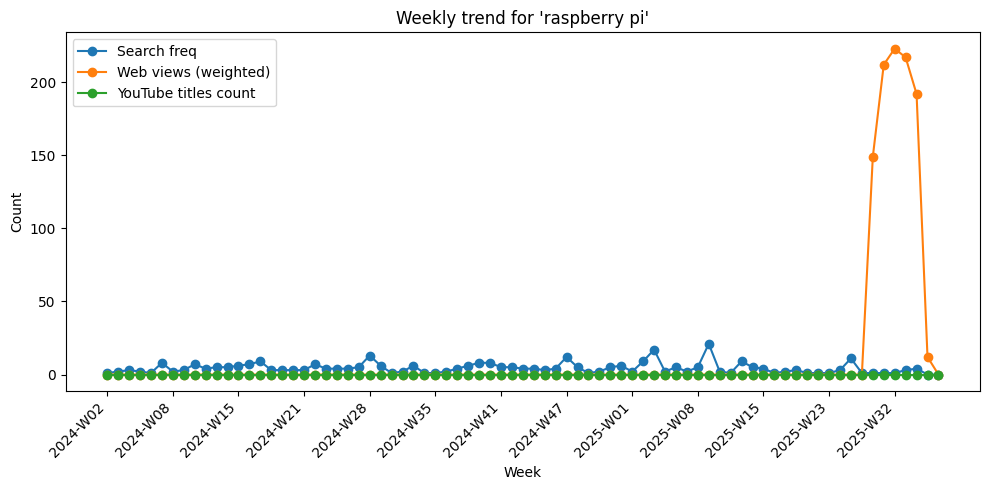

(           wk  search_freq  web_views  yt_titles
 0  2024-01-15            1          0          0
 1  2024-01-22            2          0          0
 2  2024-01-29            3          0          0
 3  2024-02-05            2          0          0
 4  2024-02-12            1          0          0
 ..        ...          ...        ...        ...
 72 2025-08-11            1        223          0
 73 2025-08-18            3        217          0
 74 2025-08-25            4        192          0
 75 2025-09-01            0         12          0
 76        NaT            0          0          0
 
 [77 rows x 4 columns],
 {'search_this': 0,
  'search_last': 0,
  'web_this': 0,
  'web_last': 12,
  'yt_this': 0,
  'yt_last': 0,
  'search_abs_change': 0,
  'web_abs_change': -12,
  'yt_abs_change': 0},
           day                                               path  views
 0  2025-08-22  https://www.kevsrobots.com/learn/docker_swarm/...   26.0
 1  2025-08-26  https://www.kevsrobots.com/lear

In [90]:
df, wow, pages = drilldown("raspberry pi")
df, wow, pages


In [91]:
# --- Saved views: weekly aggregates -----------------------------------------
con.execute("""
CREATE OR REPLACE VIEW curated.search_term_weekly AS
SELECT date_trunc('week', day) AS wk, term, SUM(freq) AS wfreq
FROM curated.term_daily
GROUP BY 1,2;
""")

con.execute("""
CREATE OR REPLACE VIEW curated.search_bigram_weekly AS
SELECT date_trunc('week', day) AS wk, bigram, SUM(freq) AS wfreq
FROM curated.bigram_daily
GROUP BY 1,2;
""")

con.execute("""
CREATE OR REPLACE VIEW curated.web_bigram_weekly AS
SELECT date_trunc('week', day) AS wk, bigram, SUM(views) AS wviews
FROM curated.web_bigrams
GROUP BY 1,2;
""")

# --- Saved views: week-over-week risers -------------------------------------
con.execute("""
CREATE OR REPLACE VIEW curated.search_bigram_risers_wow AS
WITH weekly AS (
  SELECT wk, bigram, wfreq FROM curated.search_bigram_weekly
),
growth AS (
  SELECT
    bigram, wk, wfreq,
    LAG(wfreq) OVER (PARTITION BY bigram ORDER BY wk) AS prev
  FROM weekly
)
SELECT
  bigram, wk, wfreq, prev,
  (wfreq - prev) AS s_abs_change,
  CASE WHEN prev IS NULL OR prev=0 THEN NULL
       ELSE (wfreq - prev) * 1.0 / prev
  END AS s_pct_change
FROM growth
WHERE prev IS NOT NULL;
""")

con.execute("""
CREATE OR REPLACE VIEW curated.web_bigram_risers_wow AS
WITH weekly AS (
  SELECT wk, bigram, wviews FROM curated.web_bigram_weekly
),
growth AS (
  SELECT
    bigram, wk, wviews,
    LAG(wviews) OVER (PARTITION BY bigram ORDER BY wk) AS prev
  FROM weekly
)
SELECT
  bigram, wk, wviews, prev,
  (wviews - prev) AS w_abs_change,
  CASE WHEN prev IS NULL OR prev=0 THEN NULL
       ELSE (wviews - prev) * 1.0 / prev
  END AS w_pct_change
FROM growth
WHERE prev IS NOT NULL;
""")

# --- Saved view: content gaps (search rising, web flat/slow) across all weeks
con.execute("""
CREATE OR REPLACE VIEW curated.content_gaps_allweeks AS
WITH s AS (SELECT * FROM curated.search_bigram_risers_wow),
w AS (SELECT * FROM curated.web_bigram_risers_wow)
SELECT
  s.bigram,
  s.wk,
  ROUND(s.s_pct_change*100,1) AS search_pct_up,
  COALESCE(ROUND(w.w_pct_change*100,1), 0) AS web_pct_up,
  s.s_abs_change,
  COALESCE(w.w_abs_change, 0) AS web_abs_change
FROM s
LEFT JOIN w
  ON s.bigram = w.bigram AND s.wk = w.wk
WHERE s.s_pct_change > 0
  AND (w.w_pct_change IS NULL OR w.w_pct_change <= 0.10);
""")

# --- Saved view: latest complete week only (handy default)
con.execute("""
CREATE OR REPLACE VIEW curated.content_gaps_latest AS
SELECT *
FROM curated.content_gaps_allweeks
WHERE wk = date_trunc('week', current_date) - INTERVAL 1 WEEK;
""")


CatalogException: Catalog Error: Existing object web_bigram_weekly is of type Table, trying to replace with type View

In [93]:
# Create saved views (weekly aggregates, risers, and content gaps)

con.execute("""
CREATE OR REPLACE VIEW curated.vw_search_term_weekly AS
SELECT date_trunc('week', day) AS wk, term, SUM(freq) AS wfreq
FROM curated.term_daily
GROUP BY 1,2;
""")

con.execute("""
CREATE OR REPLACE VIEW curated.vw_search_bigram_weekly AS
SELECT date_trunc('week', day) AS wk, bigram, SUM(freq) AS wfreq
FROM curated.bigram_daily
GROUP BY 1,2;
""")

con.execute("""
CREATE OR REPLACE VIEW curated.vw_web_bigram_weekly AS
SELECT date_trunc('week', day) AS wk, bigram, SUM(views) AS wviews
FROM curated.web_bigrams
GROUP BY 1,2;
""")

con.execute("""
CREATE OR REPLACE VIEW curated.vw_search_bigram_risers_wow AS
WITH weekly AS (SELECT wk, bigram, wfreq FROM curated.vw_search_bigram_weekly),
growth AS (
  SELECT bigram, wk, wfreq,
         LAG(wfreq) OVER (PARTITION BY bigram ORDER BY wk) AS prev
  FROM weekly
)
SELECT bigram, wk, wfreq, prev,
       (wfreq - prev) AS s_abs_change,
       CASE WHEN prev IS NULL OR prev=0 THEN NULL
            ELSE (wfreq - prev) * 1.0 / prev END AS s_pct_change
FROM growth
WHERE prev IS NOT NULL;
""")

con.execute("""
CREATE OR REPLACE VIEW curated.vw_web_bigram_risers_wow AS
WITH weekly AS (SELECT wk, bigram, wviews FROM curated.vw_web_bigram_weekly),
growth AS (
  SELECT bigram, wk, wviews,
         LAG(wviews) OVER (PARTITION BY bigram ORDER BY wk) AS prev
  FROM weekly
)
SELECT bigram, wk, wviews, prev,
       (wviews - prev) AS w_abs_change,
       CASE WHEN prev IS NULL OR prev=0 THEN NULL
            ELSE (wviews - prev) * 1.0 / prev END AS w_pct_change
FROM growth
WHERE prev IS NOT NULL;
""")

con.execute("""
CREATE OR REPLACE VIEW curated.vw_content_gaps_allweeks AS
WITH s AS (SELECT * FROM curated.vw_search_bigram_risers_wow),
     w AS (SELECT * FROM curated.vw_web_bigram_risers_wow)
SELECT
  s.bigram,
  s.wk,
  ROUND(s.s_pct_change*100,1)              AS search_pct_up,
  COALESCE(ROUND(w.w_pct_change*100,1), 0) AS web_pct_up,
  s.s_abs_change,
  COALESCE(w.w_abs_change, 0)              AS web_abs_change
FROM s
LEFT JOIN w ON s.bigram = w.bigram AND s.wk = w.wk
WHERE s.s_pct_change > 0
  AND (w.w_pct_change IS NULL OR w.w_pct_change <= 0.10);
""")

con.execute("""
CREATE OR REPLACE VIEW curated.vw_content_gaps_latest AS
SELECT *
FROM curated.vw_content_gaps_allweeks
WHERE wk = date_trunc('week', current_date) - INTERVAL 1 WEEK;
""")


In [94]:
con.execute("""
SELECT *
FROM curated.vw_content_gaps_latest
ORDER BY search_pct_up DESC, s_abs_change DESC
LIMIT 25;
""").fetchdf()


,bigram,wk,search_pct_up,web_pct_up,s_abs_change,web_abs_change
0,install docker,2025-08-25,400.0,0.0,4.0,0.0
1,raspberry pi,2025-08-25,33.3,-11.5,1.0,-25.0


In [95]:
# Weekly YouTube titles (for quick “is there already a video?” check)
con.execute("""
CREATE OR REPLACE VIEW curated.vw_youtube_bigram_weekly AS
SELECT date_trunc('week', published_at) AS wk, bigram, COUNT(*) AS freq
FROM curated.youtube_bigrams
WHERE published_at IS NOT NULL
GROUP BY 1,2;
""")

# “Content ideas” for the last full week: rising in search, flat on web,
# with baseline + magnitude filters and a priority score.
con.execute("""
CREATE OR REPLACE VIEW curated.vw_content_ideas_latest AS
WITH base AS (
  SELECT bigram, wk, s_abs_change, search_pct_up
  FROM curated.vw_content_gaps_latest
),
search_curr AS (
  SELECT wk, bigram, wfreq AS search_curr
  FROM curated.vw_search_bigram_weekly
),
search_prev AS (
  SELECT bigram, wk,
         LAG(wfreq) OVER (PARTITION BY bigram ORDER BY wk) AS search_prev
  FROM curated.vw_search_bigram_weekly
),
yt_8w AS (
  SELECT bigram, SUM(freq) AS yt_8w
  FROM curated.vw_youtube_bigram_weekly
  WHERE wk >= date_trunc('week', current_date) - INTERVAL 8 WEEK
  GROUP BY bigram
)
SELECT
  b.bigram,
  b.wk,
  sc.search_curr,
  sp.search_prev,
  b.s_abs_change,
  b.search_pct_up,
  COALESCE(y.yt_8w, 0) AS yt_titles_last_8w,
  (b.s_abs_change * (1 + b.search_pct_up/100.0)) AS priority
FROM base b
LEFT JOIN search_curr sc ON sc.bigram = b.bigram AND sc.wk = b.wk
LEFT JOIN search_prev sp ON sp.bigram  = b.bigram AND sp.wk = b.wk
LEFT JOIN yt_8w y        ON y.bigram   = b.bigram
WHERE COALESCE(sp.search_prev, 0) >= 3   -- baseline filter
  AND b.s_abs_change >= 3                -- magnitude filter
ORDER BY priority DESC;
""")

# Use it:
con.execute("""
SELECT *
FROM curated.vw_content_ideas_latest
ORDER BY priority DESC
LIMIT 25;
""").fetchdf()


,bigram,wk,search_curr,search_prev,s_abs_change,search_pct_up,yt_titles_last_8w,priority


In [96]:
# Each (video, bigram) counted once; then sum the video's views in its publish week
con.execute("""
CREATE OR REPLACE VIEW curated.vw_youtube_bigram_weekly_views AS
WITH uniq AS (
  SELECT DISTINCT
    yb.published_at,
    yb.source_file,
    yb.bigram
  FROM curated.youtube_bigrams yb
  WHERE yb.published_at IS NOT NULL
),
joined AS (
  SELECT
    date_trunc('week', v.published_at) AS wk,
    u.bigram,
    v.views
  FROM uniq u
  JOIN curated.youtube_videos v
    ON v.published_at = u.published_at
   AND v.source_file   = u.source_file
)
SELECT wk, bigram, SUM(views) AS wviews
FROM joined
GROUP BY 1,2;
""")


In [97]:
con.execute("""
CREATE OR REPLACE VIEW curated.vw_youtube_bigram_views_8w AS
SELECT bigram, SUM(wviews) AS yt_views_8w
FROM curated.vw_youtube_bigram_weekly_views
WHERE wk >= date_trunc('week', current_date) - INTERVAL 8 WEEK
GROUP BY 1;
""")


In [98]:
con.execute("""
CREATE OR REPLACE VIEW curated.vw_content_ideas_weighted_latest AS
WITH base AS (
  SELECT bigram, wk, s_abs_change, search_pct_up
  FROM curated.vw_content_gaps_latest
),
search_curr AS (
  SELECT wk, bigram, wfreq AS search_curr
  FROM curated.vw_search_bigram_weekly
),
search_prev AS (
  SELECT bigram, wk,
         LAG(wfreq) OVER (PARTITION BY bigram ORDER BY wk) AS search_prev
  FROM curated.vw_search_bigram_weekly
),
yt8 AS (
  SELECT bigram, yt_views_8w
  FROM curated.vw_youtube_bigram_views_8w
)
SELECT
  b.bigram,
  b.wk,
  sc.search_curr,
  sp.search_prev,
  b.s_abs_change,
  b.search_pct_up,
  COALESCE(yt8.yt_views_8w, 0) AS yt_views_last_8w,
  -- base priority (same as before)
  (b.s_abs_change * (1 + b.search_pct_up/100.0)) AS priority,
  -- supply-gap score: downweight if lots of YT coverage in last 8 weeks
  ROUND((b.s_abs_change * (1 + b.search_pct_up/100.0)) * (1.0 / (1.0 + COALESCE(yt8.yt_views_8w,0)/10000.0)), 2) AS supply_gap_score
FROM base b
LEFT JOIN search_curr sc ON sc.bigram = b.bigram AND sc.wk = b.wk
LEFT JOIN search_prev sp ON sp.bigram  = b.bigram AND sp.wk = b.wk
LEFT JOIN yt8        ON yt8.bigram     = b.bigram
WHERE COALESCE(sp.search_prev, 0) >= 3  -- baseline
  AND b.s_abs_change >= 3               -- magnitude
ORDER BY supply_gap_score DESC, priority DESC;
""")


In [99]:
con.execute("""
SELECT *
FROM curated.vw_content_ideas_weighted_latest
ORDER BY supply_gap_score DESC
LIMIT 25;
""").fetchdf()


,bigram,wk,search_curr,search_prev,s_abs_change,search_pct_up,yt_views_last_8w,priority,supply_gap_score


In [100]:
# Looser, weighted ideas for the last full week
con.execute("""
CREATE OR REPLACE VIEW curated.vw_content_ideas_weighted_latest_loose AS
WITH base AS (
  SELECT bigram, wk, s_abs_change, search_pct_up
  FROM curated.vw_content_gaps_latest
),
search_curr AS (
  SELECT wk, bigram, wfreq AS search_curr
  FROM curated.vw_search_bigram_weekly
),
search_prev AS (
  SELECT bigram, wk,
         LAG(wfreq) OVER (PARTITION BY bigram ORDER BY wk) AS search_prev
  FROM curated.vw_search_bigram_weekly
),
yt8 AS (
  SELECT bigram, yt_views_8w
  FROM curated.vw_youtube_bigram_views_8w
)
SELECT
  b.bigram,
  b.wk,
  sc.search_curr,
  sp.search_prev,
  b.s_abs_change,
  b.search_pct_up,
  COALESCE(yt8.yt_views_8w, 0) AS yt_views_last_8w,
  (b.s_abs_change * (1 + b.search_pct_up/100.0)) AS priority,
  ROUND((b.s_abs_change * (1 + b.search_pct_up/100.0)) * (1.0 / (1.0 + COALESCE(yt8.yt_views_8w,0)/10000.0)), 2) AS supply_gap_score
FROM base b
LEFT JOIN search_curr sc ON sc.bigram = b.bigram AND sc.wk = b.wk
LEFT JOIN search_prev sp ON sp.bigram  = b.bigram AND sp.wk = b.wk
LEFT JOIN yt8        ON yt8.bigram     = b.bigram
WHERE COALESCE(sp.search_prev, 0) >= 1
  AND b.s_abs_change >= 1
ORDER BY supply_gap_score DESC, priority DESC;
""")

# Try it
con.execute("""
SELECT *
FROM curated.vw_content_ideas_weighted_latest_loose
ORDER BY supply_gap_score DESC
LIMIT 25;
""").fetchdf()


,bigram,wk,search_curr,search_prev,s_abs_change,search_pct_up,yt_views_last_8w,priority,supply_gap_score
0,install docker,2025-08-25,5.0,1.0,4.0,400.0,0.0,20.000,20.00
1,raspberry pi,2025-08-25,4.0,3.0,1.0,33.3,0.0,1.333,1.33
